In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations, plot_decision, perform_hierarchical_clustering, \
                       plot_dendrogram, extract_clustering, get_class_occurences_in_clusters 
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree, print_diro2c_rules
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [3]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([1.11018683]), array([[-0.02146303,  0.02909487]]))

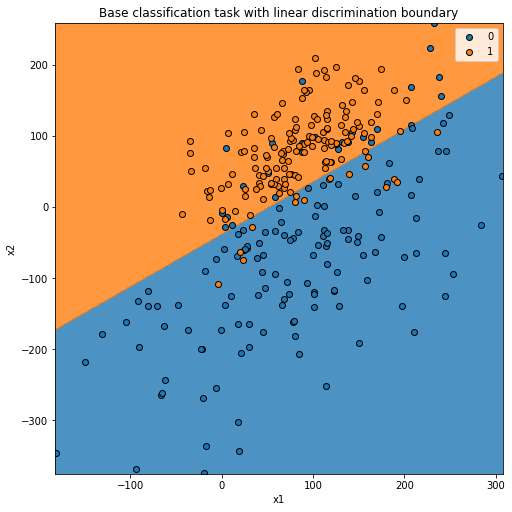

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_,
                       fig=fig, ax=ax)

In [5]:
clf_a = lm

In [6]:
from sklearn.dummy import DummyClassifier
clf_b = DummyClassifier(strategy='uniform', random_state=0)
clf_b.fit(X, y)

DummyClassifier(random_state=0, strategy='uniform')

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

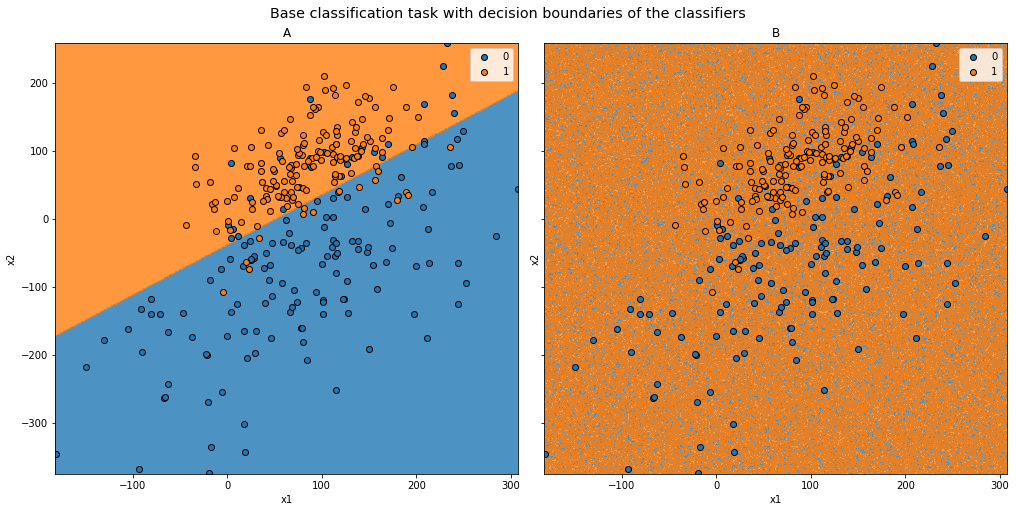

In [8]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', mesh_step_size=1)

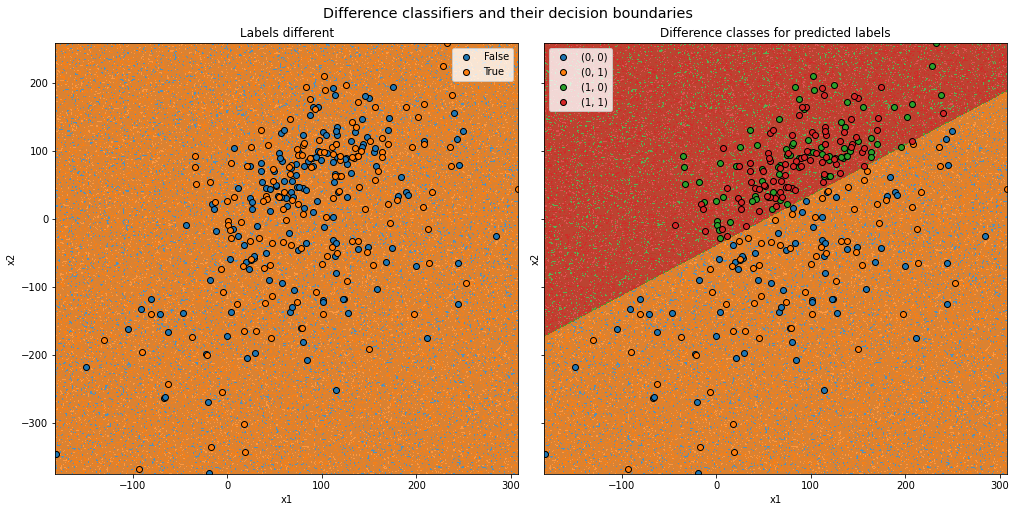

In [9]:
comparer.plot_decision_boundaries(X, mesh_step_size=1)

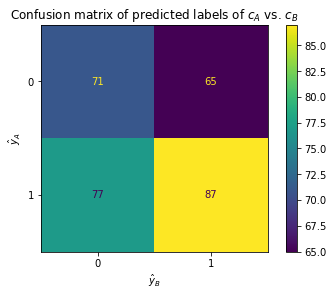

In [10]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [11]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 7.8 s, sys: 234 ms, total: 8.04 s
Wall time: 9.31 s


In [12]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## Traditional Approach

### Feature importance

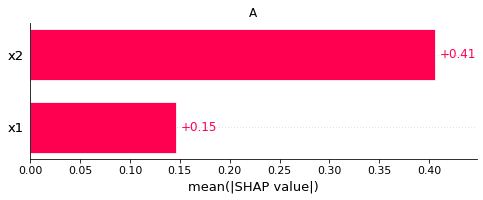

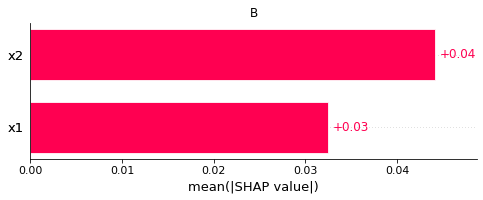

In [13]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])
plot_feature_importance_bar(explanations.indiv.labels.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.labels.B[:, :, 1], title='B', feature_order=feature_order)

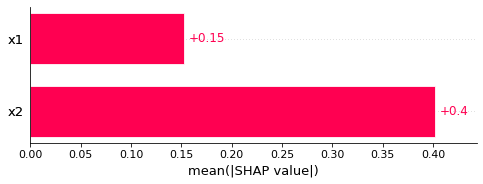

In [14]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

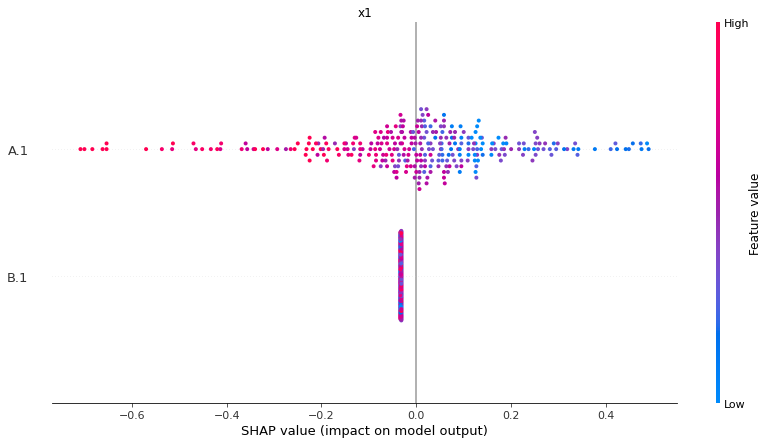

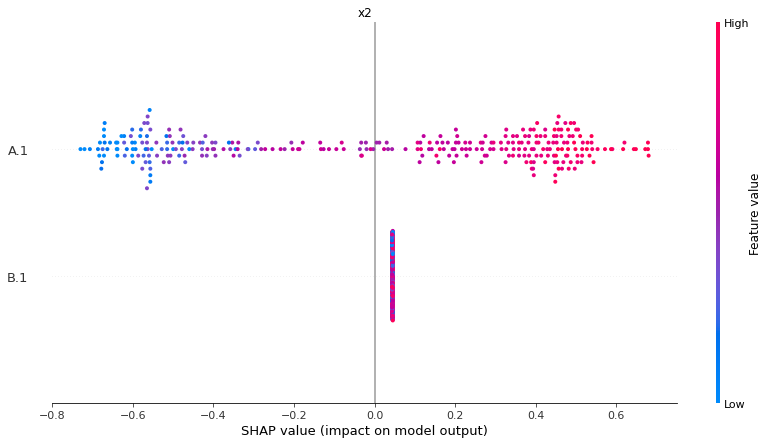

In [15]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Feature Effects

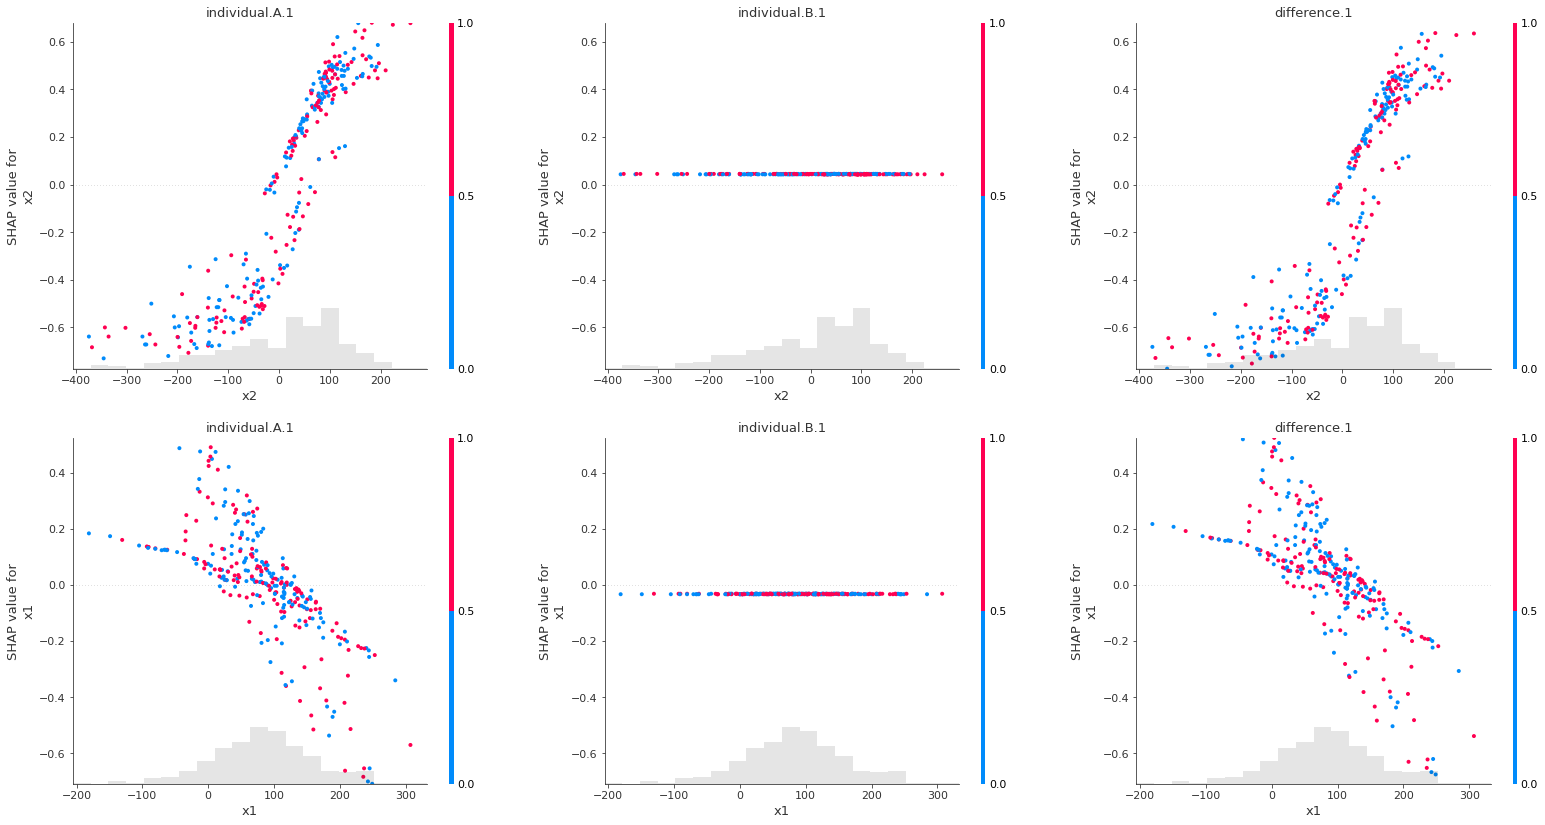

In [16]:
plot_feature_effects(merge_explanations(individual=explanations.indiv.labels[:, feature_order, 1],
                                        difference=explanations.indiv_diff.labels[:, feature_order, 1]),
                     color=is_pred_diff)

## Difference classifier explanations

### Feature importance

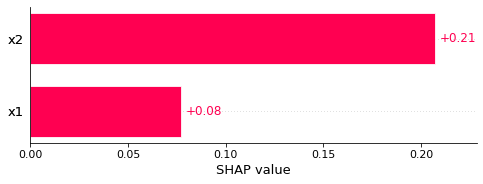

In [17]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, 1])
plot_feature_importance_bar(feature_importance)

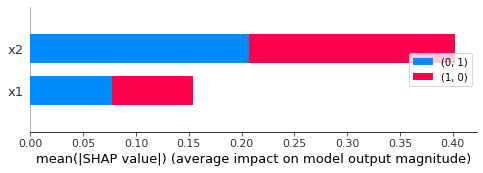

In [18]:
plot_feature_importance_bar(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])

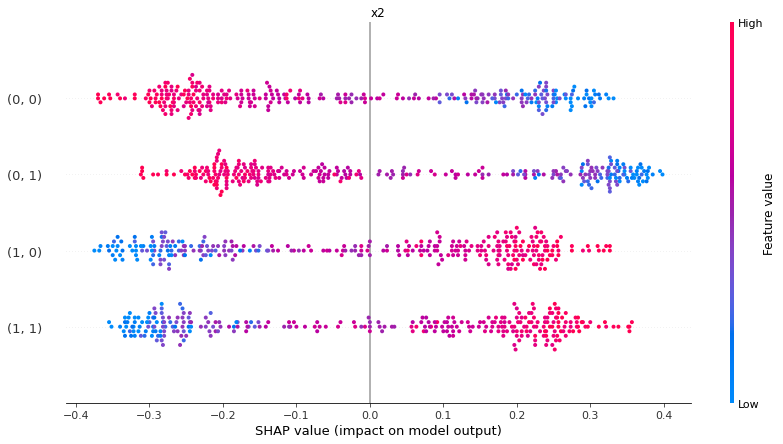

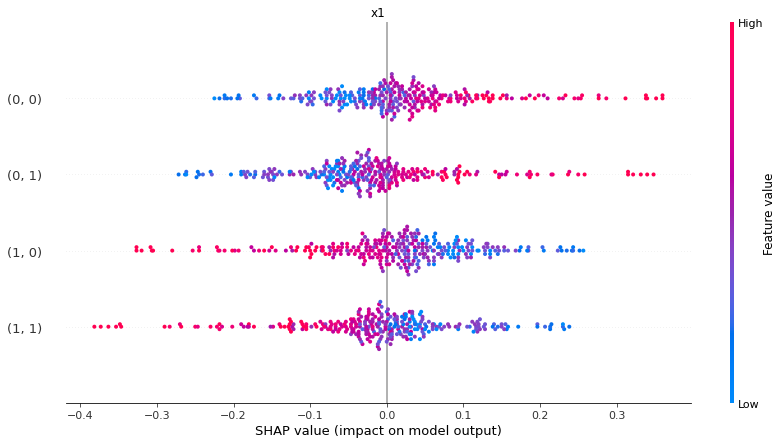

In [19]:
plot_feature_importance_scatter(explanations.mclass_diff.labels[:, feature_order])

### Feature effects

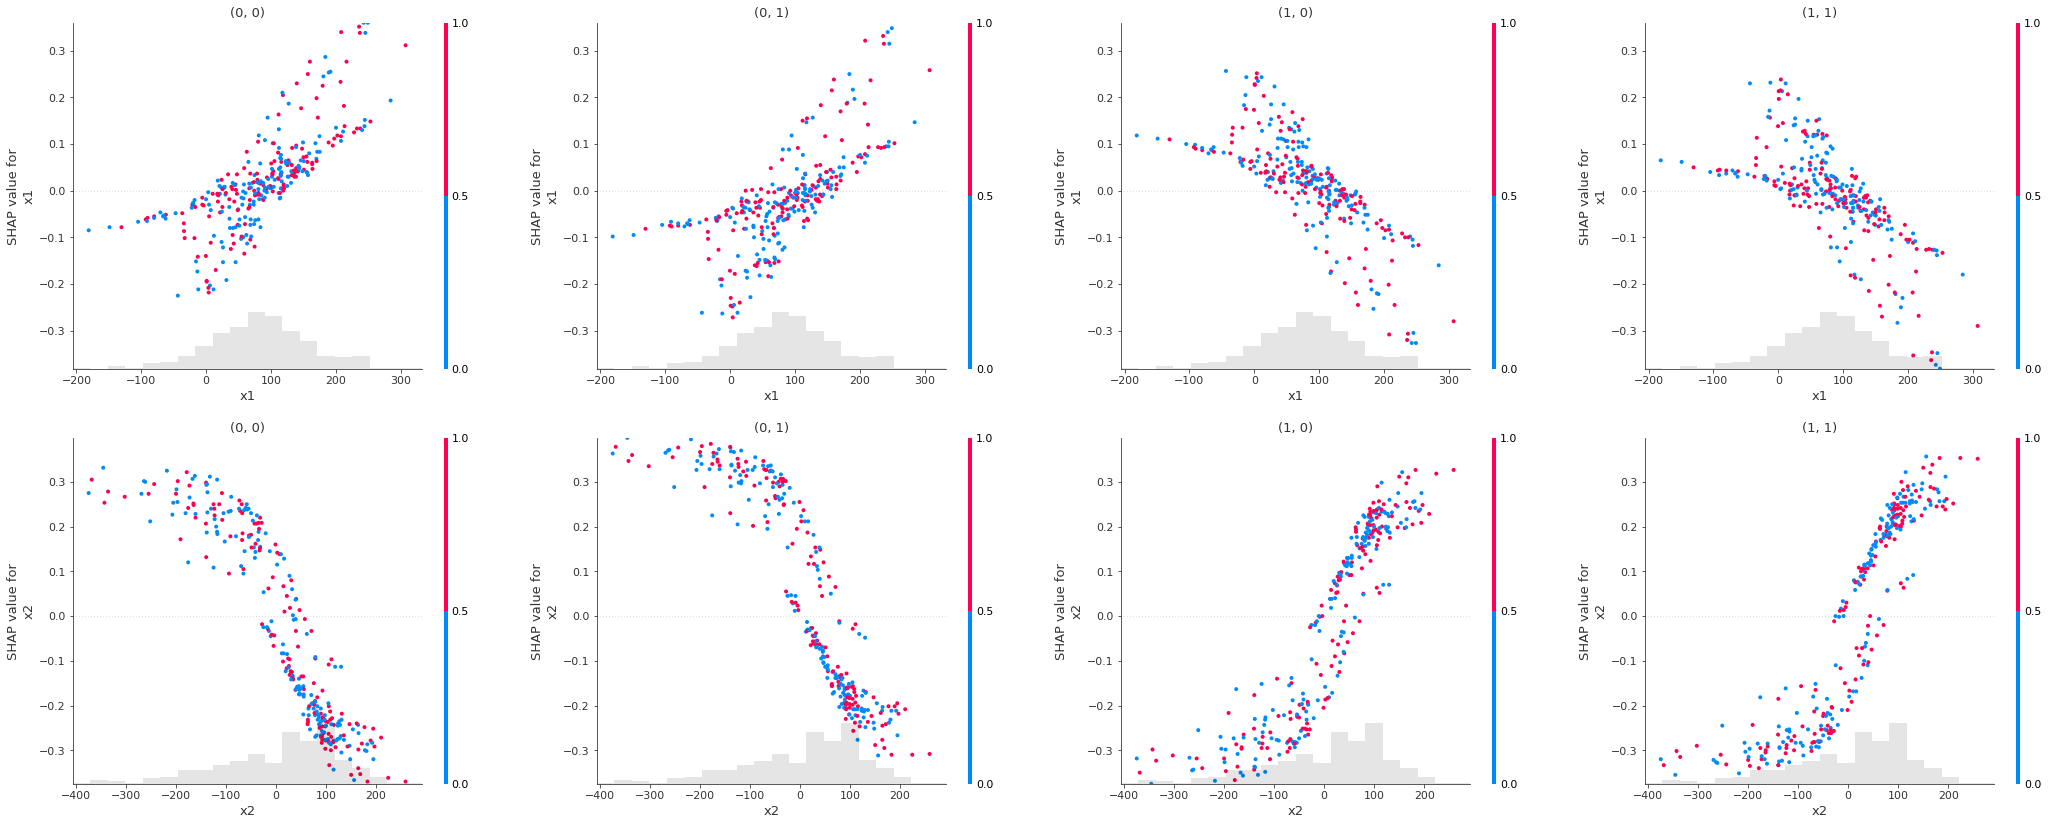

In [20]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

# Local Explanations

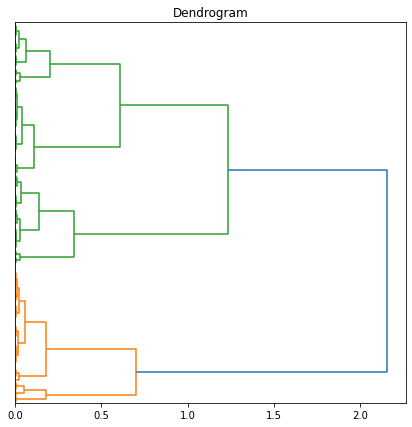

In [21]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

In [25]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,0,0
c2,0,0,39,53
c3,0,0,31,41
c4,56,63,0,0


In [26]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,42,50
c2,59,60,33,39


In [27]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=3)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,42,50
c2,0,0,31,41
c3,56,63,0,0


In [28]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=5)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,0,0
c2,0,0,39,53
c3,0,0,31,41
c4,31,40,0,0
c5,19,29,0,0


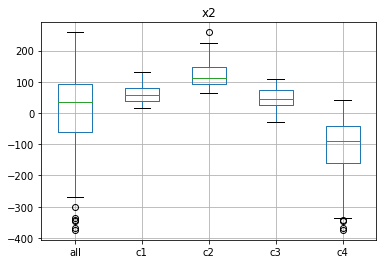

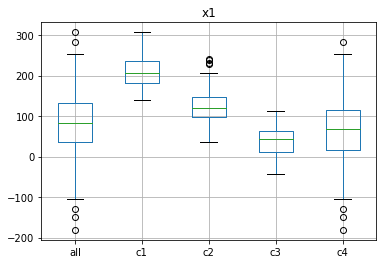

In [29]:
for feature_name in comparer.feature_names[feature_order]:
    df = pd.concat([pd.Series(explanations[:, feature_name].data)] +
                   [pd.Series(explanations_clustered.mclass_diff.labels.cohorts[cluster][:, feature_name].data)
                    for cluster in clusters_of_interest], axis=1)
    df.columns = ['all'] + clusters_of_interest.tolist()
    df.boxplot()
    plt.title(feature_name)
    plt.show()

## 1st Cluster

In [46]:
cluster = clusters_of_interest[0]
cluster

'c1'

In [47]:
confusion_class = '(0, 1)'
shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

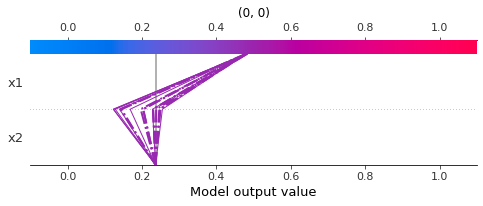

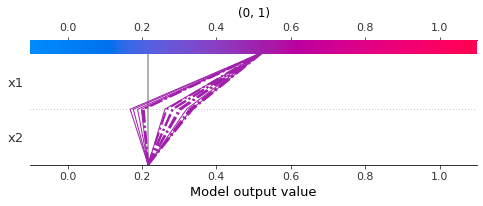

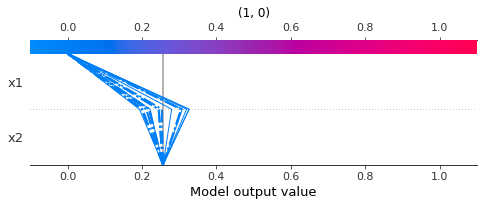

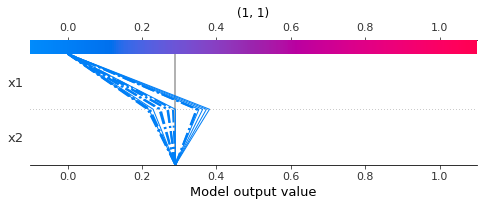

In [48]:
plot_decision(shap_values, highlight=instances_confused, xlim=(-0.1, 1.1))

### Feature importances

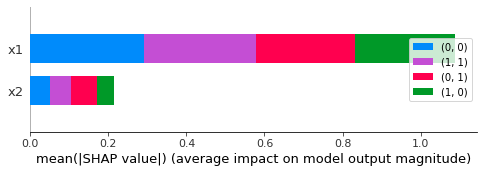

In [59]:
plot_feature_importance_bar(shap_values)

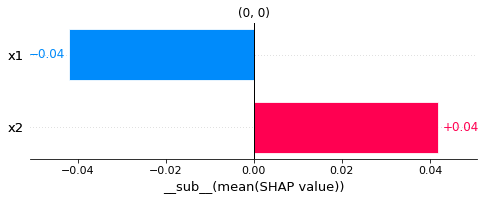

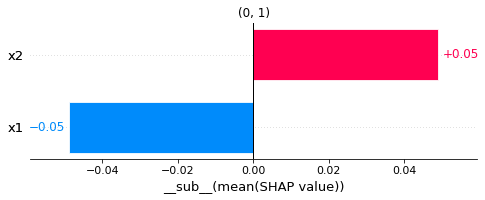

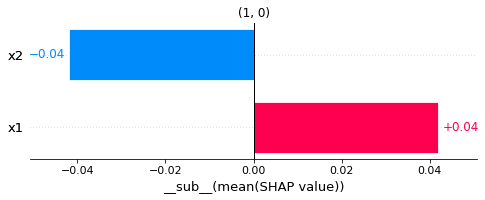

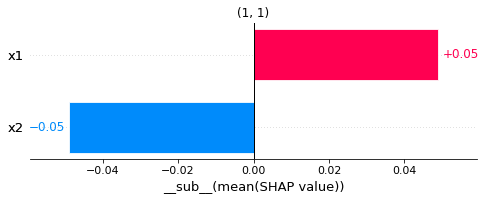

In [63]:
for class_ in comparer.class_names:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

### Feature effects

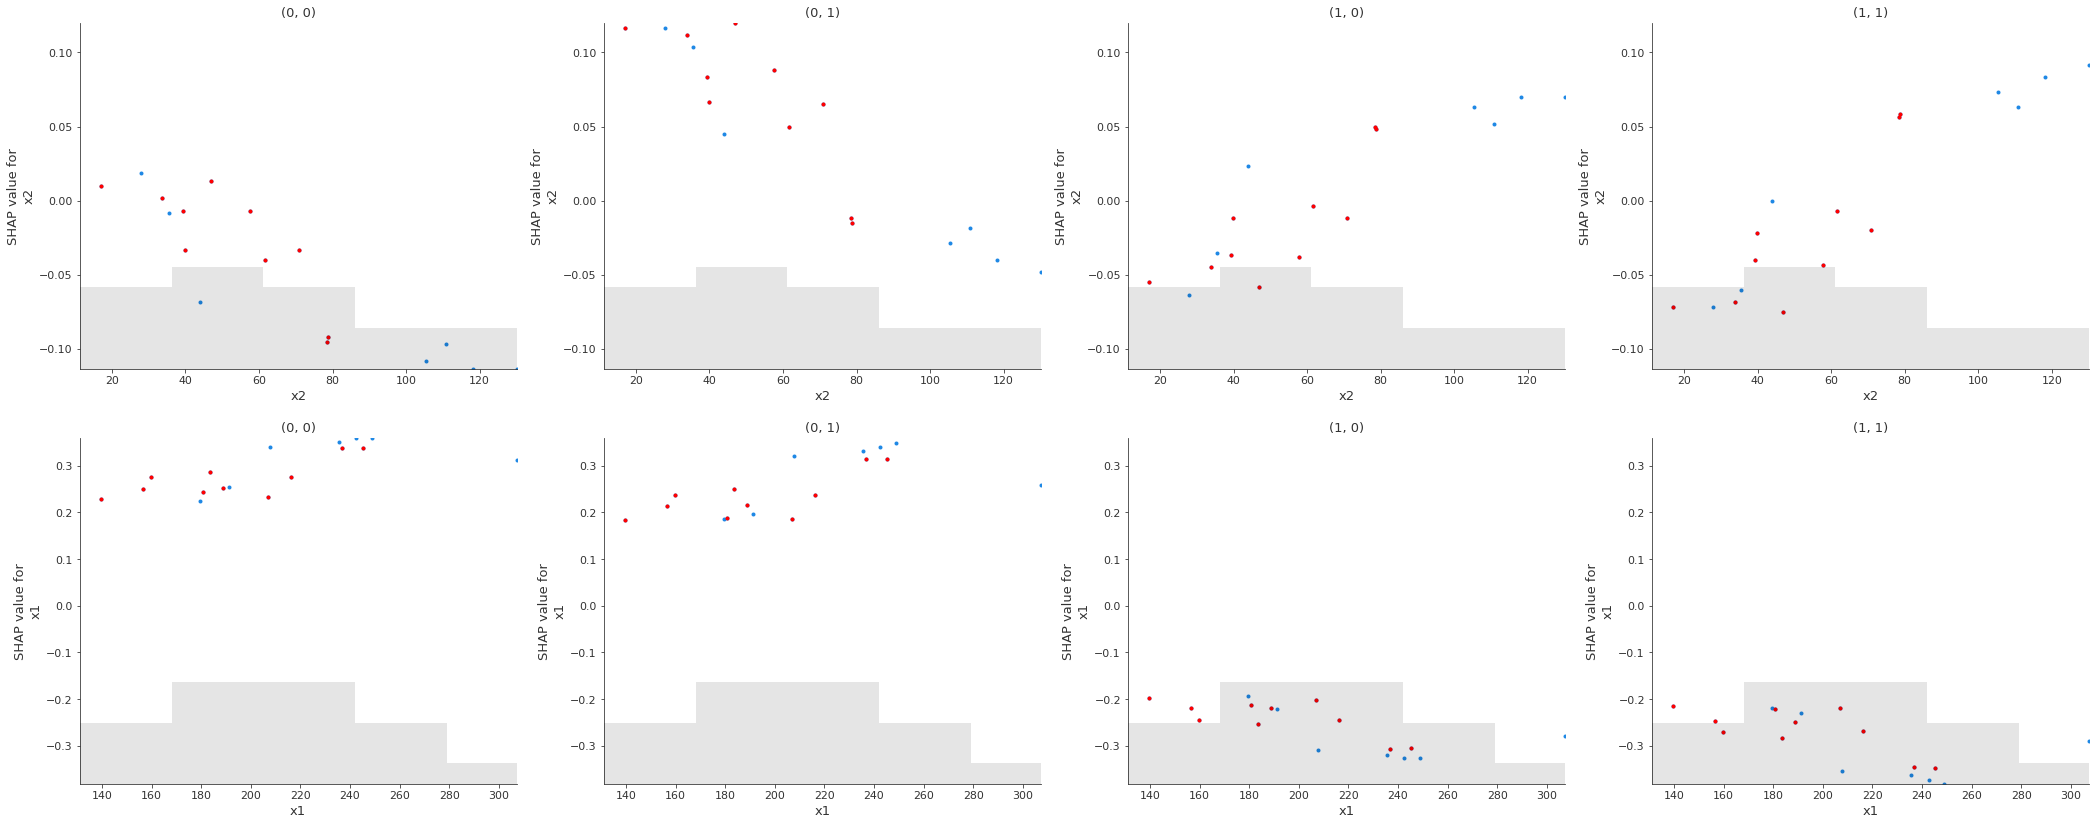

In [34]:
plot_feature_effects(shap_values[:, feature_order], highlight=instances_confused)

### diro2c

In [35]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
explanation = generate_diro2c_explanation(X, idx_explain, comparer, confusion_class)

CPU times: user 33.8 s, sys: 789 ms, total: 34.6 s
Wall time: 39.4 s


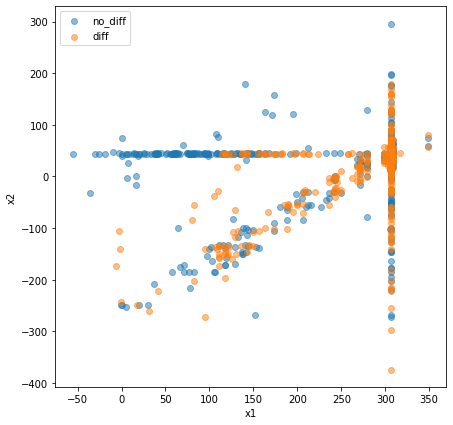

In [36]:
plot_diro2c_2d(explanation, 'x1', 'x2')

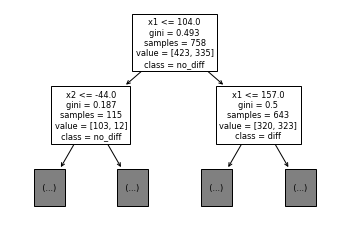

In [37]:
plot_diro2c_tree(explanation, max_depth=1)

## 2nd Cluster

In [64]:
cluster = clusters_of_interest[1]
cluster

'c2'

In [65]:
confusion_class = '(1, 0)'
shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

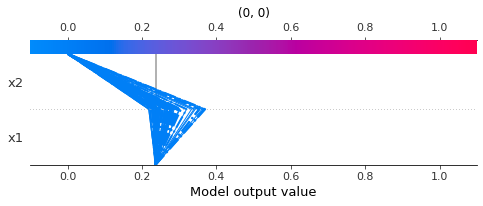

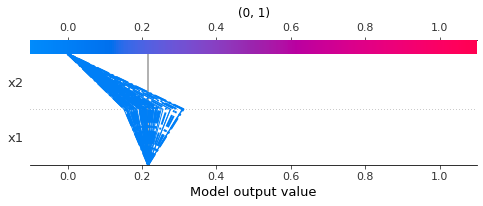

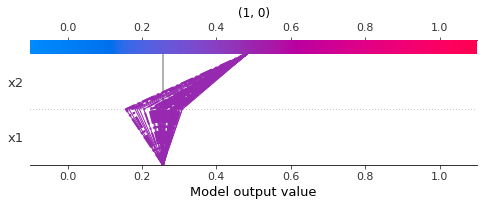

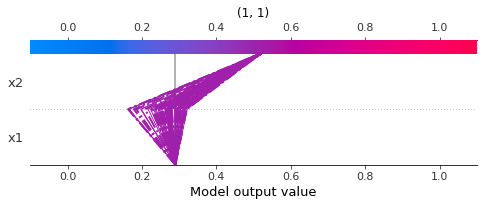

In [66]:
plot_decision(shap_values, highlight=instances_confused, xlim=(-0.1, 1.1))

### Feature importances

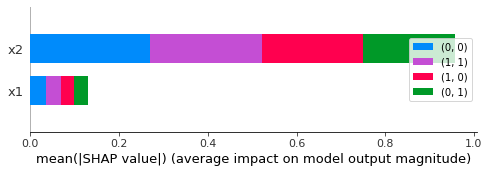

In [67]:
plot_feature_importance_bar(shap_values)

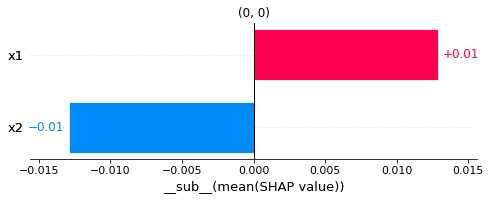

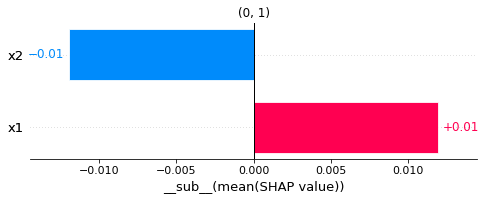

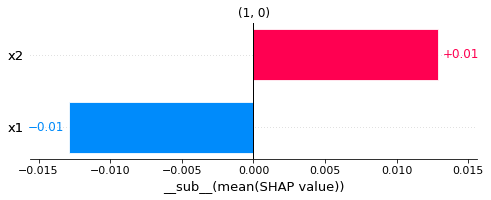

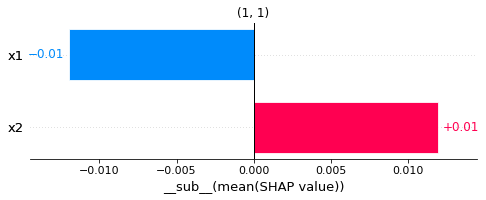

In [68]:
for class_ in comparer.class_names:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

### Feature effects

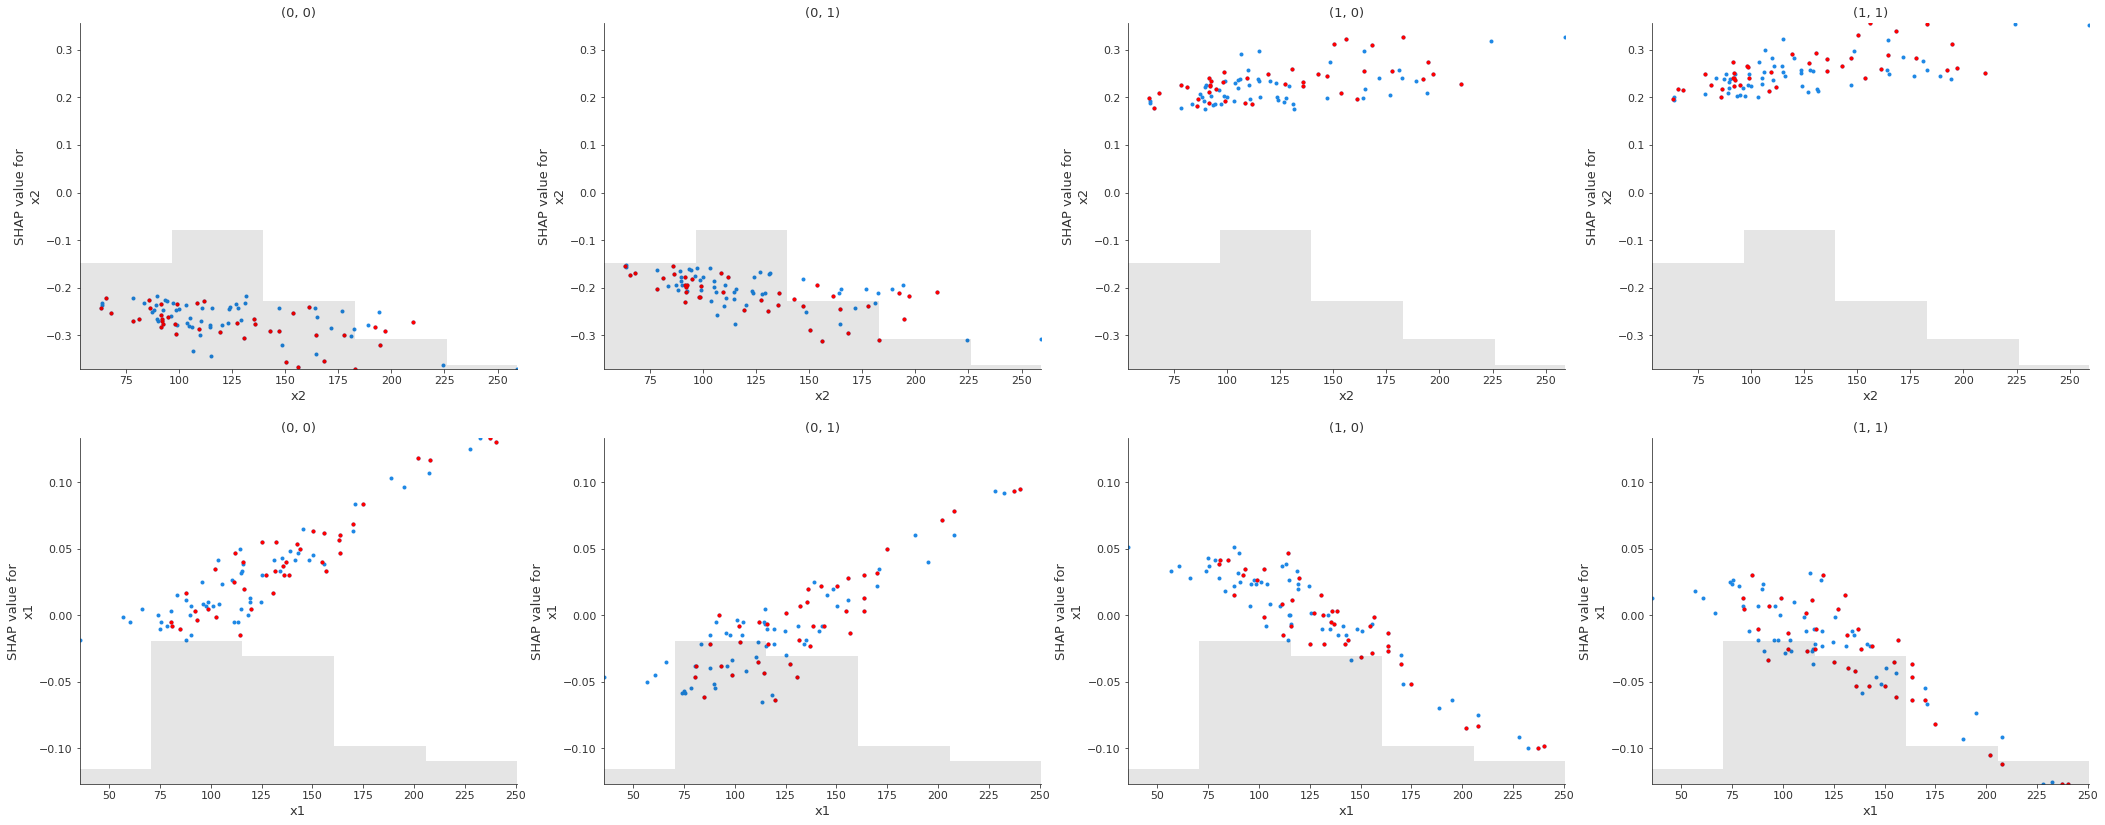

In [69]:
plot_feature_effects(shap_values[:, feature_order], highlight=instances_confused)

### diro2c

In [43]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
explanation = generate_diro2c_explanation(X, idx_explain, comparer, confusion_class)

CPU times: user 33.3 s, sys: 739 ms, total: 34.1 s
Wall time: 37.7 s


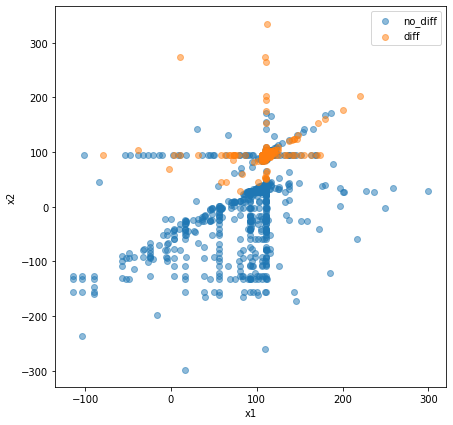

In [44]:
plot_diro2c_2d(explanation, 'x1', 'x2')

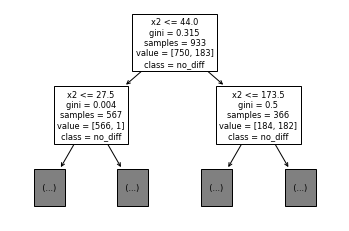

In [45]:
plot_diro2c_tree(explanation, max_depth=1)

## 3rd Cluster

In [70]:
cluster = clusters_of_interest[2]
cluster

'c3'

In [71]:
confusion_class = '(1, 0)'
shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

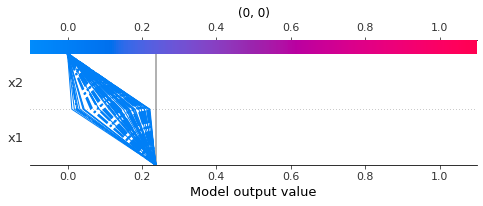

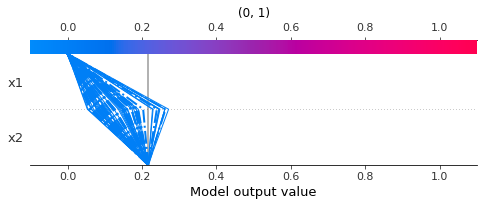

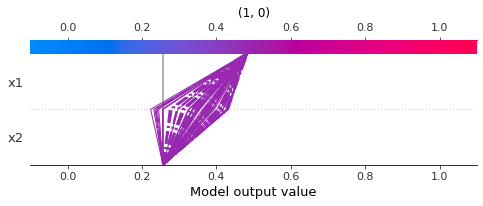

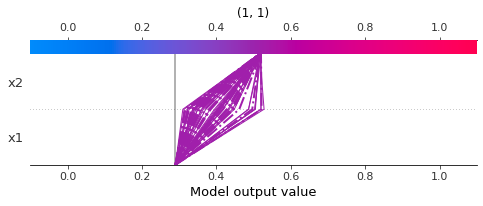

In [72]:
plot_decision(shap_values, highlight=instances_confused, xlim=(-0.1, 1.1))

### Feature importances

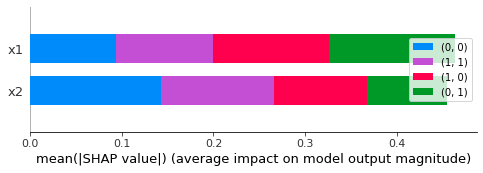

In [73]:
plot_feature_importance_bar(shap_values)

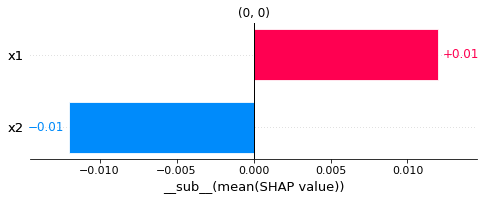

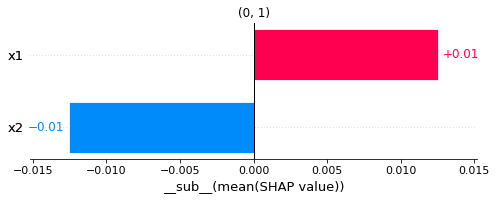

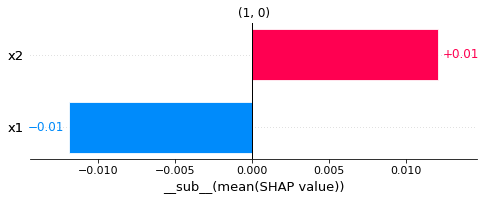

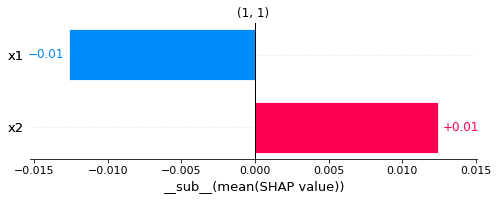

In [74]:
for class_ in comparer.class_names:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

### Feature effects

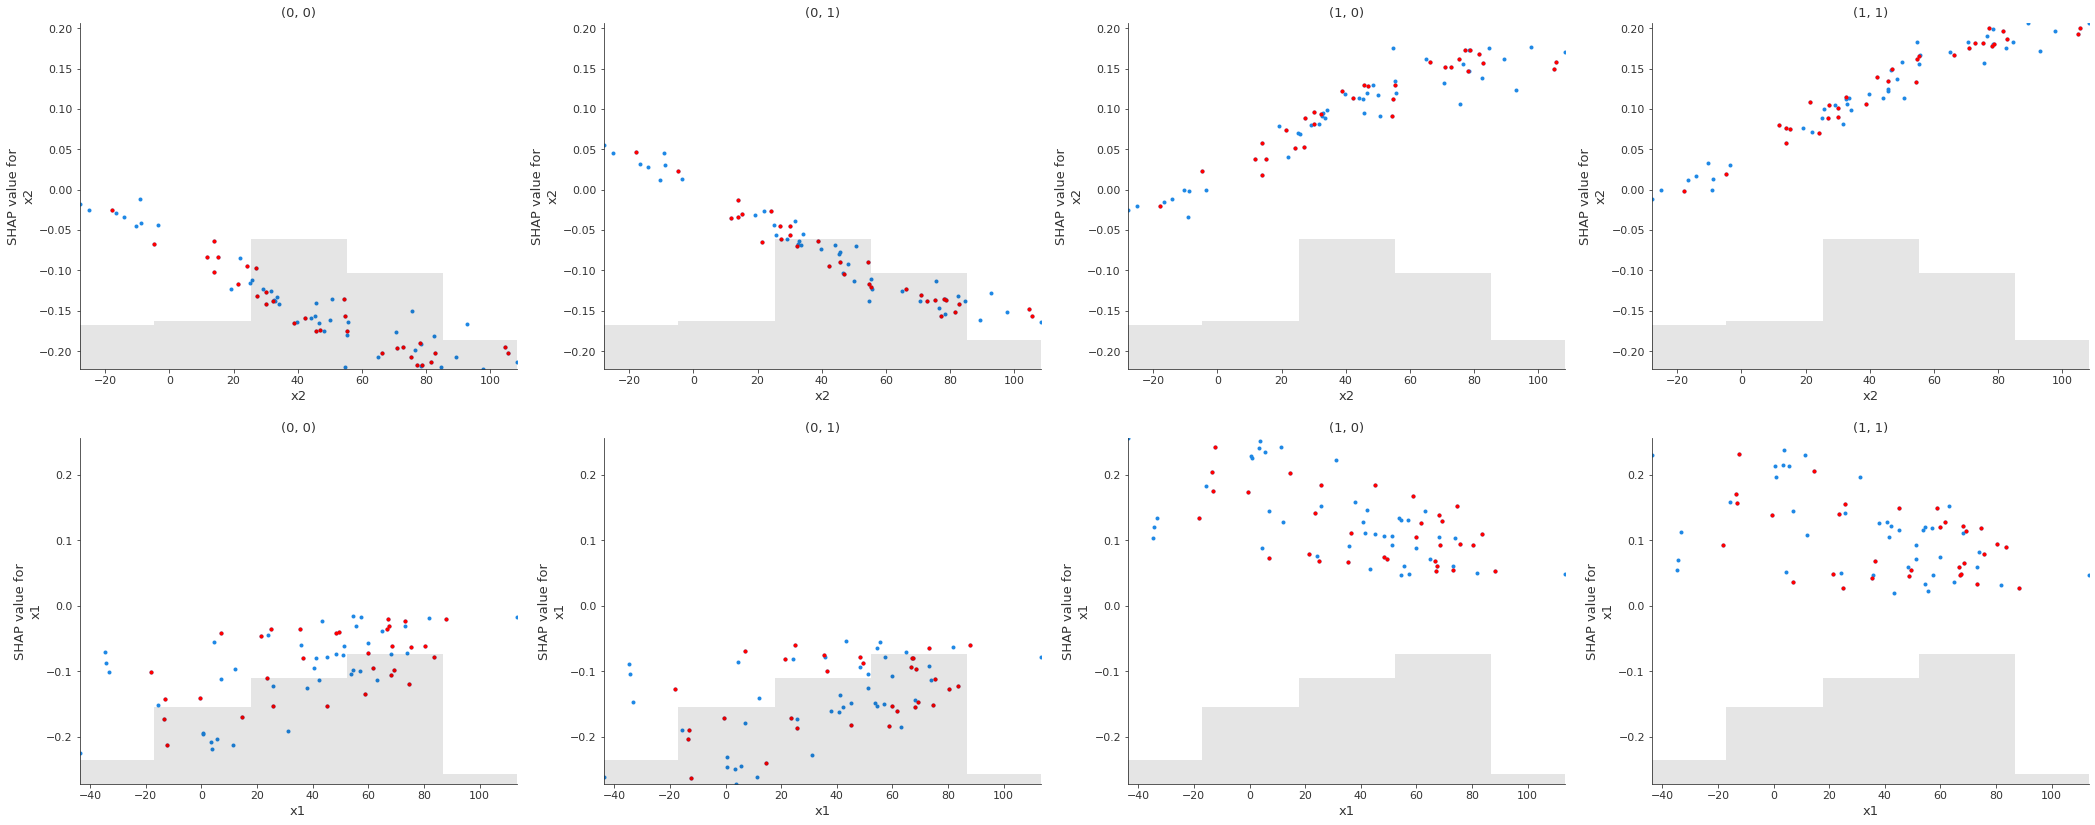

In [75]:
plot_feature_effects(shap_values[:, feature_order], highlight=instances_confused)

### diro2c

In [76]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
explanation = generate_diro2c_explanation(X, idx_explain, comparer, confusion_class)

CPU times: user 24.8 s, sys: 332 ms, total: 25.1 s
Wall time: 27.2 s


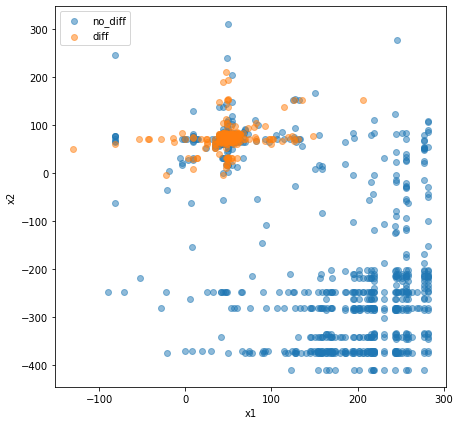

In [77]:
plot_diro2c_2d(explanation, 'x1', 'x2')

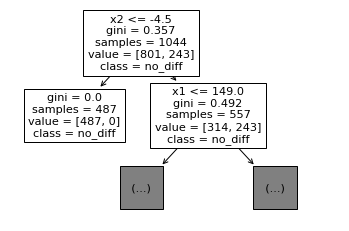

In [78]:
plot_diro2c_tree(explanation, max_depth=1)

## 4th Cluster

In [79]:
cluster = clusters_of_interest[3]
cluster

'c4'

In [82]:
confusion_class = '(0, 1)'
shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

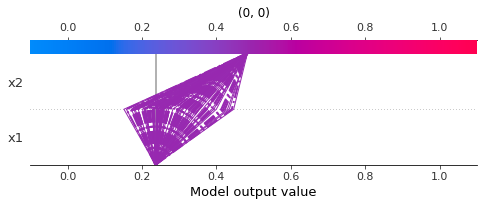

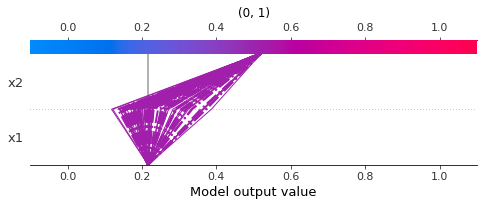

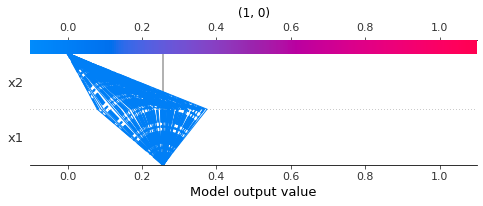

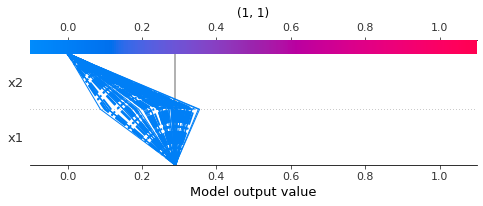

In [83]:
plot_decision(shap_values, highlight=instances_confused, xlim=(-0.1, 1.1))

### Feature importances

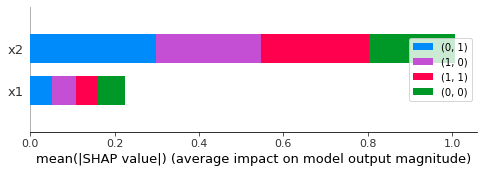

In [84]:
plot_feature_importance_bar(shap_values)

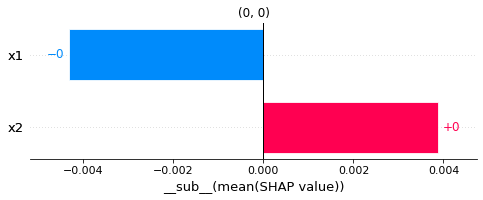

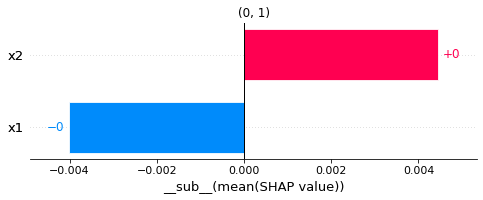

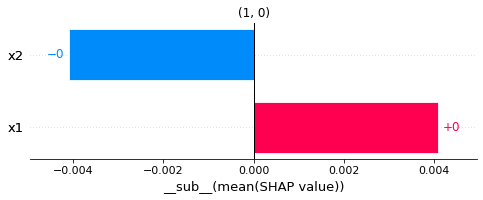

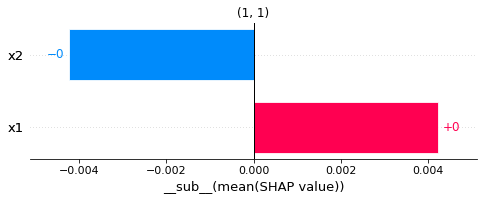

In [85]:
for class_ in comparer.class_names:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

### Feature effects

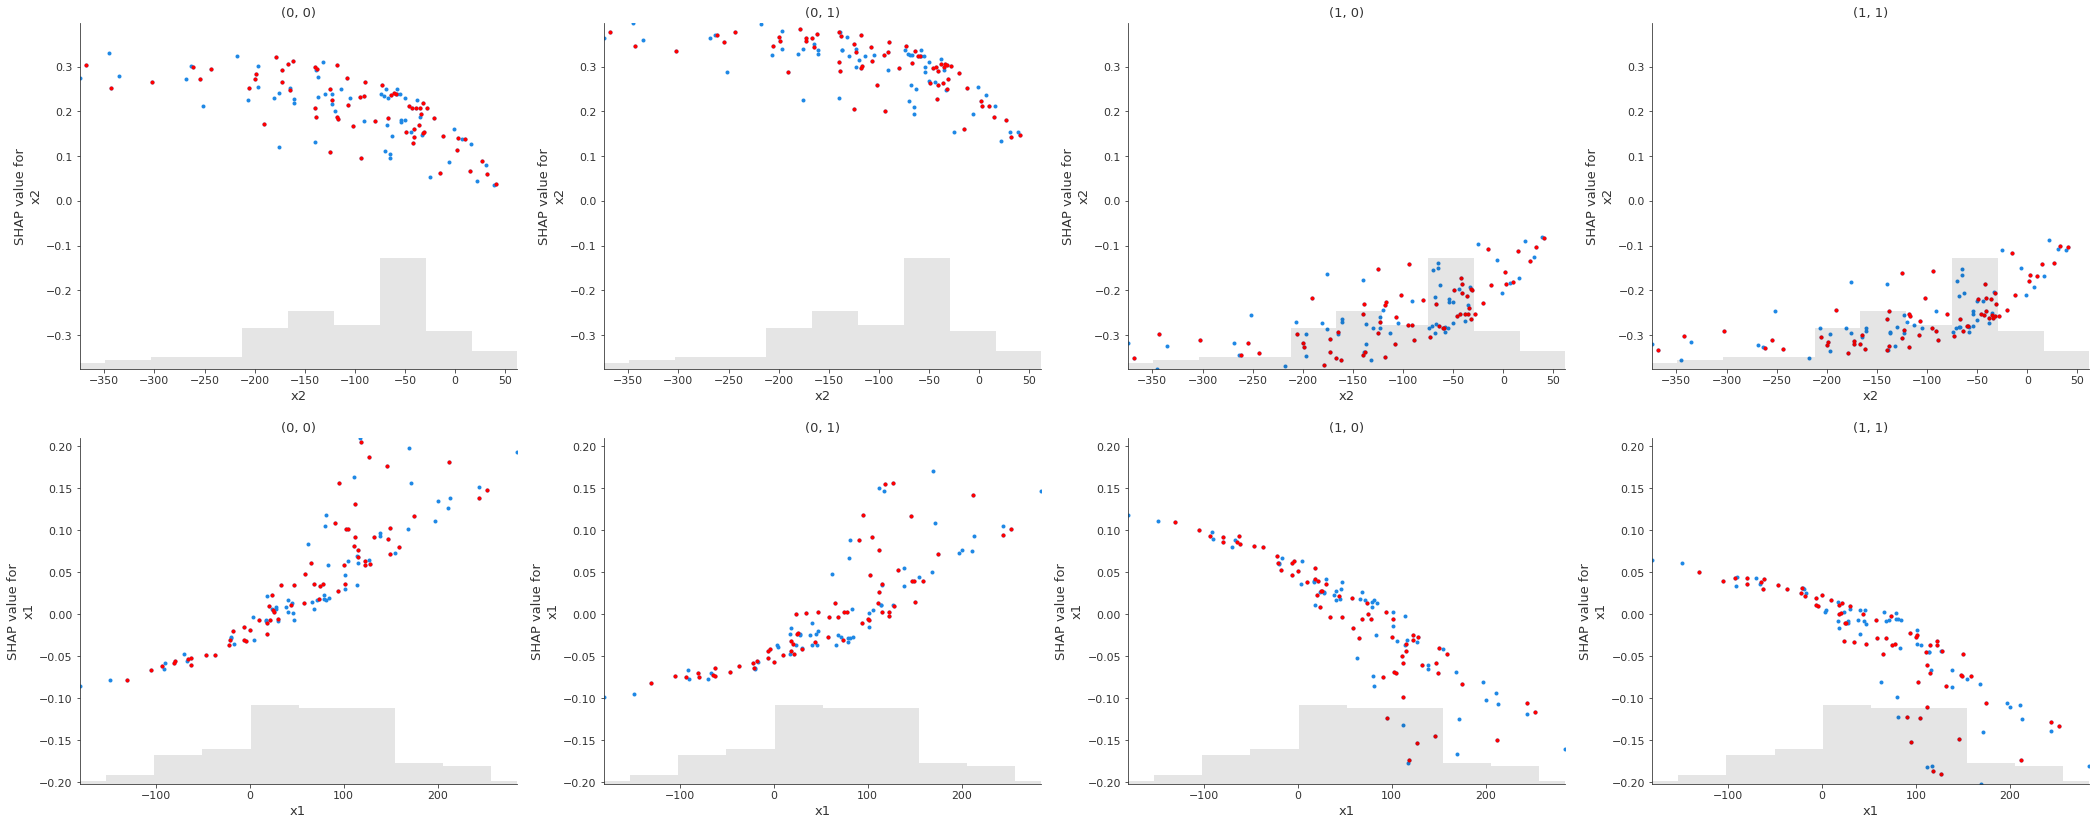

In [86]:
plot_feature_effects(shap_values[:, feature_order], highlight=instances_confused)

### diro2c

In [87]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
explanation = generate_diro2c_explanation(X, idx_explain, comparer, confusion_class)

CPU times: user 23 s, sys: 229 ms, total: 23.2 s
Wall time: 23.9 s


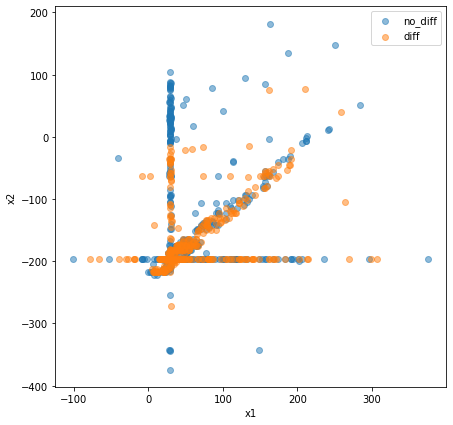

In [88]:
plot_diro2c_2d(explanation, 'x1', 'x2')

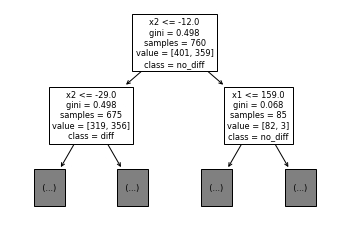

In [89]:
plot_diro2c_tree(explanation, max_depth=1)